# Thresholding Notebook

Use this notebook to test out thresholds for different projects/imagesets. Parameters are values you'll need to set before you start then skip down to the "Thresholding" section to begin modifying the candidate threshold values. 

## Parameters

`project_name`: Name you chose for your project 

`image_file_name`: Example image you plan to use 

`cell_index`: Start with 0, there's always a 0th cell. Then use Figure 1 to determine which cell you would like to specifically work with. 


In [2]:
# Change this project name to the name of your current project
project_name = "example_project"

# Change this filename to change the image that will be loaded
image_file_name = "160503 1 kPa + Supp 60x_Multichannel_20160503_05 - GFP Deck-1.vsi.tif"

cell_index = 0

color_continuous = (0,100,255) 
color_punctate = (255,0,200) 
color_perpendicular = (100,210,240) 
color_nojunct = (255,255,255)

# Some features are nearby but don't intersect, if you want those colored 
# set this to a color otherwise set it to None
#color_none = (255,255,255)
color_none = None

In [3]:
# Notebook specific shim code - you can ignore this section. All this does
# is load the code directory so we can import functions from it, set up 
# the graphing and import some modules only used in this notebook. 
%matplotlib notebook 
# auto 
# inline

import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
codedir = parentdir + "/code"
sys.path.insert(0, codedir) 

import json
import pickle

import ipywidgets as widgets

from matplotlib import pyplot

import cv2
import numpy
import scipy

import skimage.draw

from skimage.morphology import disk, white_tophat

from cells.edge import segments
from cells.edge import classify

import cells.images.filter
import cells.waypoints.perimeter
import cells.waypoints.seeding

from cells.edge import classify, segments, junctions

c:\python27\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


<IPython.core.display.Javascript object>


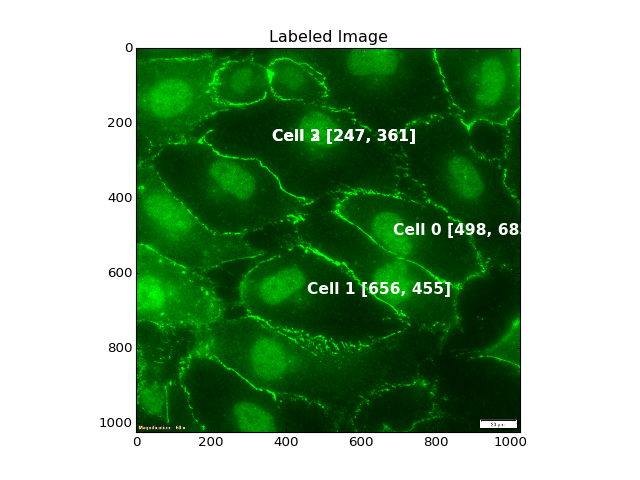

In [4]:

output_prefix = image_file_name.replace(".vsi.tif", "")

##### Use this section if staining TxRed images with GFP as primary value. 
##### If another stain is being used, replace accordingly so GFP is replaced with the primary value 
##### and TxRed is replaced with the other stain or identifier 

if "TxRed" in image_file_name:
    reference_image_file_name = image_file_name.replace("TxRed", "GFP")
else:
    reference_image_file_name = image_file_name

############################


####If only using one stain that isn't GFP, use this section instead:
    
#reference_image_file_name = image_file_name


############################
    
    
    
project_directory = os.path.join(parentdir, "data", "projects", project_name)

# Load Image
images_directory = os.path.join(project_directory, "input", "images")
image_file = os.path.join(images_directory, image_file_name)
input_image = cv2.imread(image_file)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

# Filter image, generate useful images
input_image = cells.images.filter.remove_legend(input_image, None)
# image_intensity = cells.images.filter.convert_intensity(input_image, (1, 0, 0))
#cost_image = cells.images.filter.generate_cost_image(image_intensity)

image_intensity, image_cost = \
            cells.images.filter.filter_image(input_image)

cost_image = image_cost

# Load Waypoints
waypoints_directory = os.path.join(project_directory, "artifacts", "waypoints")
current_wp_filename = reference_image_file_name + ".tsv"
current_wp_file = os.path.join(waypoints_directory, current_wp_filename)
image_waypoints = cells.waypoints.seeding.load_waypoints(current_wp_file)

waypoints_collection = []
for iwp in image_waypoints:
    waypoints_collection.append(iwp.get("waypoints"))
    
# Show image and annotate centers
pyplot.figure(1)
pyplot.title('Labeled Image')
pyplot.imshow(input_image)
for cell_idx in range(0, len(image_waypoints)):
    r, c = image_waypoints[cell_idx].get("geometric_center")
    label = "Cell %s [%s, %s]" % (str(cell_idx), str(r), str(c))
    pyplot.annotate(label, [c, r], color="white", fontsize=14, fontweight= 'bold')
pyplot.show()


In [5]:
print "Cell Center: ", image_waypoints[cell_index].get("geometric_center")

Cell Center:  [498, 685]


<IPython.core.display.Javascript object>


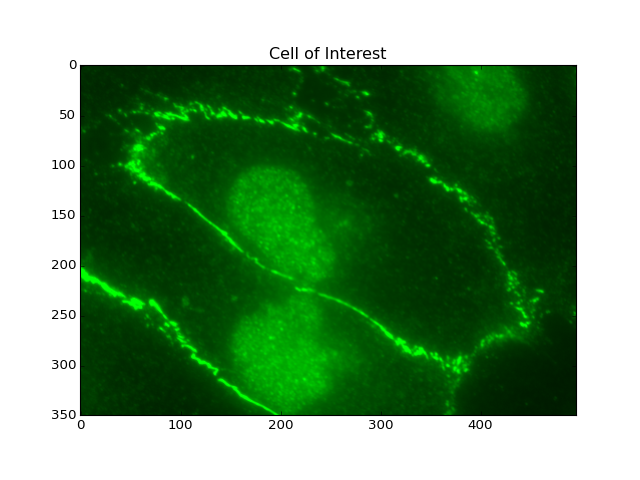

In [6]:
waypoints = numpy.asarray(image_waypoints[cell_index].get("waypoints"))

r_cell_min, r_cell_max = numpy.min(waypoints[:, 0]), numpy.max(waypoints[:, 0])
c_cell_min, c_cell_max = numpy.min(waypoints[:, 1]), numpy.max(waypoints[:, 1])

i_r_max, i_c_max, depth = input_image.shape
frame_r_min, frame_r_max = max([r_cell_min - 50, 0]), min([r_cell_max + 50, i_r_max])
frame_c_min, frame_c_max = max([c_cell_min - 50, 0]), min([c_cell_max + 50, i_c_max])

pyplot.figure(2)
pyplot.title('Cell of Interest')
pyplot.imshow(input_image[frame_r_min:frame_r_max, frame_c_min:frame_c_max])
pyplot.show()

## Threshold Value Selection

Modify this `filter_threshold` value to find the value that you need. 

<IPython.core.display.Javascript object>


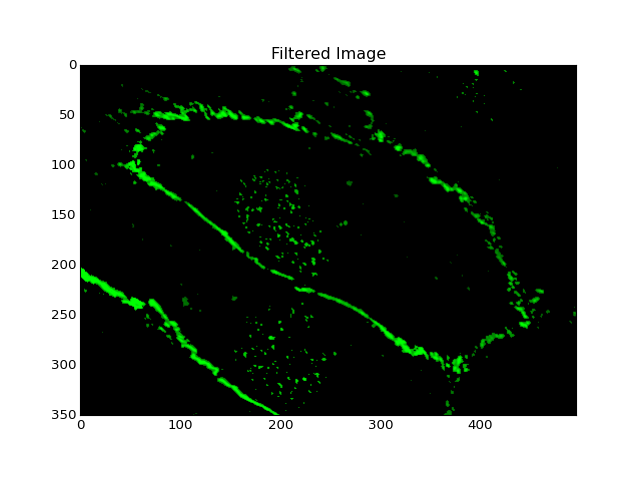

In [7]:
filter_threshold = 15

selem = disk(5)
image_processed = white_tophat(image_intensity, selem)


plotter = numpy.zeros(input_image.shape, dtype=numpy.uint8)
plotter[image_processed > filter_threshold] = input_image[image_processed > filter_threshold]

pyplot.figure(3)
pyplot.title('Filtered Image')
pyplot.imshow(plotter[frame_r_min:frame_r_max, frame_c_min:frame_c_max])
pyplot.show()

Perimeter (pixels):  880


<IPython.core.display.Javascript object>


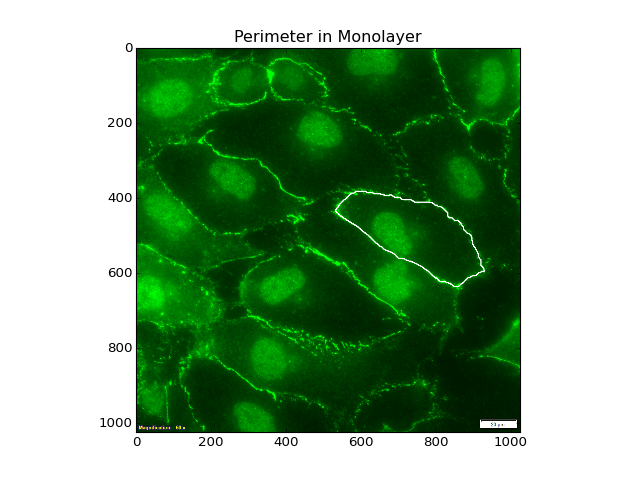

<IPython.core.display.Javascript object>


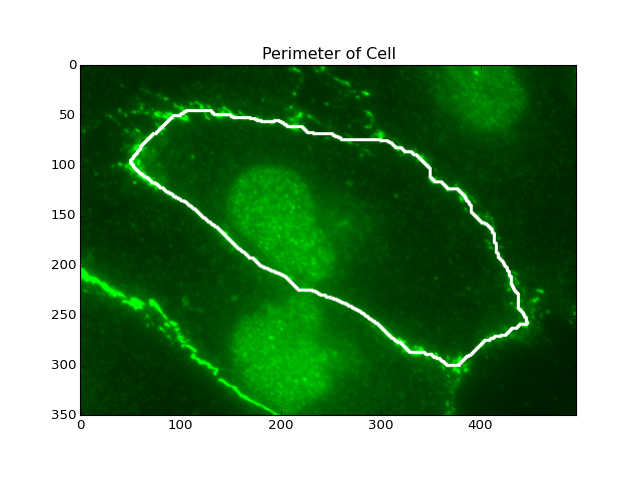

True

In [8]:
waypoints = numpy.asarray(image_waypoints[cell_index].get("waypoints"))
perimeter_cost_image = cells.images.filter.generate_cost_image_perimeter(input_image)
perimeter = cells.waypoints.perimeter.get_perimeter(perimeter_cost_image, waypoints)

r_cell_min, r_cell_max = numpy.min(waypoints[:, 0]), numpy.max(waypoints[:, 0])
c_cell_min, c_cell_max = numpy.min(waypoints[:, 1]), numpy.max(waypoints[:, 1])

i_r_max, i_c_max, depth = input_image.shape
frame_r_min, frame_r_max = max([r_cell_min - 50, 0]), min([r_cell_max + 50, i_r_max])
frame_c_min, frame_c_max = max([c_cell_min - 50, 0]), min([c_cell_max + 50, i_c_max])

plotter = input_image.copy()

path = numpy.asarray(perimeter)

for e in path:
    r, c = e
    
    thickness_radius = 2 # Change me
    rr, cc = skimage.draw.circle(r, c, thickness_radius)
    skimage.draw.set_color(plotter, (rr, cc), (255,255,255))
    
print "Perimeter (pixels): ", len(perimeter)

pyplot.figure(4)
pyplot.title('Perimeter in Monolayer')
pyplot.imshow(plotter)
pyplot.show()

pyplot.figure(5)
pyplot.title('Perimeter of Cell')
pyplot.imshow(plotter[frame_r_min:frame_r_max, frame_c_min:frame_c_max])
pyplot.show()

plotter = numpy.zeros(input_image.shape, dtype=numpy.uint8)
plotter[image_processed > filter_threshold] = input_image[image_processed > filter_threshold]
skimage.draw.set_color(plotter, (rr, cc), (255, 255, 255))

cv2.imwrite(output_prefix + ' perimeter.png', plotter)

In [9]:
feature_mask = segments.get_feature_mask(image_processed, filter_threshold)

window_size = 5
segment_data, feature_objects = \
    junctions.get_subfeature_edge_data(feature_mask, perimeter, window_size)



<IPython.core.display.Javascript object>


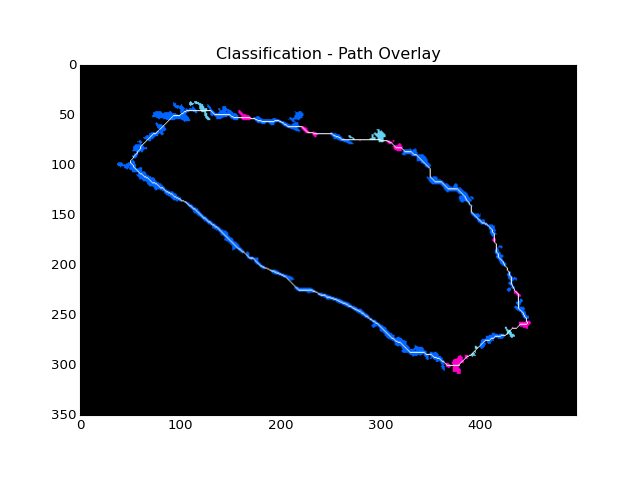

<IPython.core.display.Javascript object>


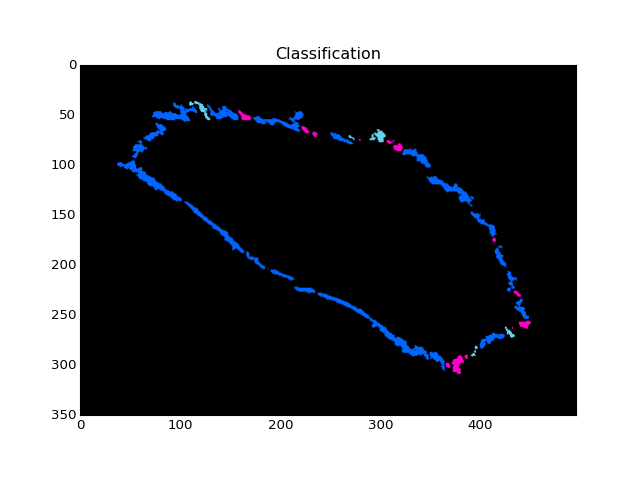

<IPython.core.display.Javascript object>


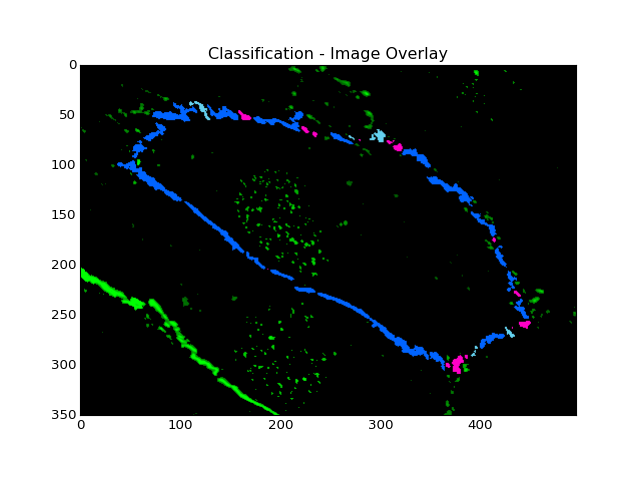

<IPython.core.display.Javascript object>


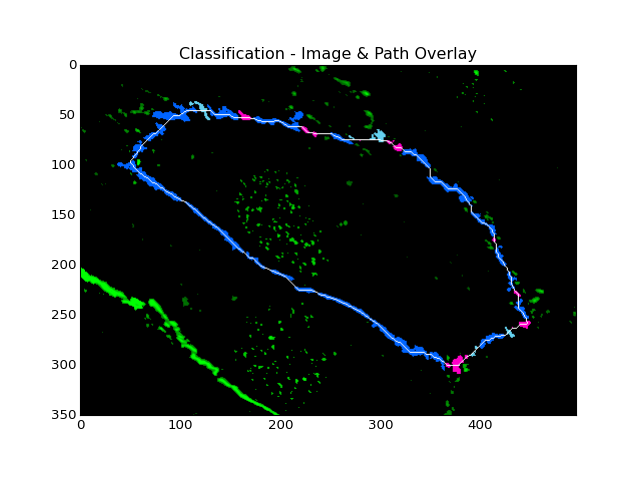

In [10]:
fc_features_raw = feature_objects
fc_details_raw = segment_data

plotter = numpy.zeros(input_image.shape, dtype=numpy.uint8)
plotter_class = numpy.zeros(input_image.shape, dtype=numpy.uint8)

plotter_ol = numpy.zeros(input_image.shape, dtype=numpy.uint8)
plotter_ol[image_processed > filter_threshold] = input_image[image_processed > filter_threshold]

plotter_olp = numpy.zeros(input_image.shape, dtype=numpy.uint8)
plotter_olp[image_processed > filter_threshold] = input_image[image_processed > filter_threshold]

plotter_fg = plotter.copy()


dup_dict = {}

blend_factor = 0.5

for key, value in fc_features_raw.iteritems():
    fc_cur = None
    for fc_d in fc_details_raw:
        if fc_d["feature_idx"] == key:
            ## Change
            if fc_cur is None:
                fc_cur = fc_d
            elif fc_d["classification"] == "Continuous":
                fc_cur = fc_d
            ## End Change
            
    
    if fc_cur is None:
        for e in value:
            r, c = e
                
            if color_none is not None:
                plotter[r, c, :] = color_none
                plotter_class[r, c, :] = color_none
                plotter_ol[r,c,:] = color_none
                plotter_olp[r,c,:] = color_none
            
    else:
        #if dup_dict.get(key) is None:
        #    dup_dict[key] = [fc_cur["classification"]]
        #else:
        #    dup_dict[key].append(fc_cur["classification"])
        #    
        #if fc_cur["classification"] == "Perpendicular":
        #    
        #    print key
        #    for fc_d in fc_details_raw:
        #        if fc_d["feature_idx"] == key:
        #            print fc_d
           
        for e in value:
            r, c = e
            if fc_cur["classification"] == "Continuous":
                plotter[r, c, :] = color_continuous
                plotter_class[r, c, :] = color_continuous
                plotter_ol[r, c, :] = color_continuous
                plotter_olp[r, c, :] = color_continuous
            elif fc_cur["classification"] == "Punctate":
                plotter[r, c, :] = color_punctate
                plotter_class[r, c, :] = color_punctate
                plotter_ol[r, c, :] = color_punctate
                plotter_olp[r, c, :] = color_punctate
            elif fc_cur["classification"] == "Perpendicular":
                plotter[r, c, :] = color_perpendicular
                plotter_class[r, c, :] = color_perpendicular
                plotter_ol[r, c, :] = color_perpendicular
                plotter_olp[r, c, :] = color_perpendicular
                
            else:
                print "?"
    

plotter_bg = plotter.copy()

for e in perimeter:
    r,c = e
    plotter[r,c,:] = (255,255,255)
    plotter_olp[r,c,:] = (255,255,255)
    plotter_fg[r,c,:] = (255,255,255)

    
pyplot.figure(6)
pyplot.title('Classification - Path Overlay')
pyplot.imshow(plotter[frame_r_min:frame_r_max, frame_c_min:frame_c_max])
pyplot.show()

pyplot.figure(7)
pyplot.title('Classification')
pyplot.imshow(plotter_class[frame_r_min:frame_r_max, frame_c_min:frame_c_max])
pyplot.show()

pyplot.figure(8)
pyplot.title('Classification - Image Overlay')
pyplot.imshow(plotter_ol[frame_r_min:frame_r_max, frame_c_min:frame_c_max])
pyplot.show()

pyplot.figure(9)
pyplot.title('Classification - Image & Path Overlay')
pyplot.imshow(plotter_olp[frame_r_min:frame_r_max, frame_c_min:frame_c_max])
pyplot.show()


## Uncommenting these lines will save the generated images

#cv2.imwrite(output_prefix + ' junctions.png', plotter)
#cv2.imwrite(output_prefix + ' junctions no path.png', plotter_class)
#cv2.imwrite(output_prefix + ' junctions overlay.png', plotter_ol)
#cv2.imwrite(output_prefix + ' junctions overlay path.png', plotter_olp)
